In [1]:
import optris_csv as ocsv
from matplotlib.pyplot import cm
import matplotlib
import temperaturemap as tmap
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, correlate, medfilt
from scipy.optimize import curve_fit
import scipy.stats
%matplotlib widget
import pandas as pd
from scipy.special import erf
import seaborn as sns
from matplotlib.lines import Line2D

import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = str([r'\usepackage{amsmath}'])

print(f"Using temperature calibration version {tmap.VERSION}.")

sns.set_theme()

Using temperature calibration version 3.1.


In [28]:
data = ocsv.OptrisDataset("./hopefully not.dat").build_array_data()
TIME_CUTOFF = 2000
data = data[data["time"] <= TIME_CUTOFF]
OPTRIS_SIGMA = 0.5

def pad_indices(indices, window):
    padleft, padright = window
    total_width = padleft + padright + 1
    output = np.zeros((*np.shape(indices), total_width), dtype=int)
    output[...,padleft] = indices
    for col in range(padleft):
        output[..., col] = output[...,padleft] - (padleft - col) * np.ones(len(indices))
    for col in range(padleft + 1, total_width):
        output[..., col] = output[...,padleft] + (padright + col - total_width + 1) * np.ones(len(indices))

    output[output <= 0] = 0
    
    return output

def get_highest_window_value(data, indices, window):
    return np.max(data[pad_indices(indices, window)], axis=-1)
# print(data.keys())

112


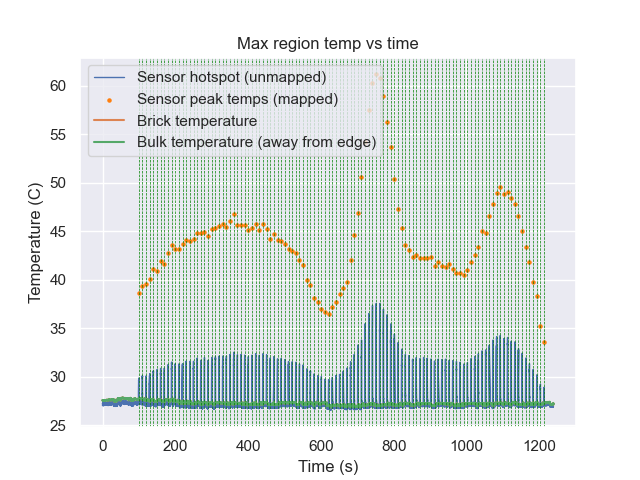

In [32]:
fig, ax = plt.subplots()
time = data["time"]

        
EDGEKEY = "Chip Periphery Left"
LASEKEY = "ROI"

BRICKKEY = "tape brick"
SLABKEY = "tape brick"
    
si_map = tmap.maps["Si_Bright"].true_temperature
si_sigma_map = tmap.maps["Si_Bright"].propagate_error

Al_map = tmap.maps["Al"].true_temperature
Al_sigma_map = tmap.maps["Al"].propagate_error

raw_edge_data = data[EDGEKEY]

edge_temp_sigma = OPTRIS_SIGMA * np.ones(len(raw_edge_data))
edge_background = si_map(medfilt(raw_edge_data, kernel_size=301))

max_chip_temps = data[LASEKEY]
chip_background = Al_map(medfilt(savgol_filter(max_chip_temps, 72, 4), kernel_size=301))
max_chip_temps_mapped = Al_map(savgol_filter(max_chip_temps, 72, 4))
max_chip_delta = max_chip_temps_mapped - chip_background + edge_background

# ax.plot(time, max_chip_temps_mapped, label="Sensor hotspot (mapped)", lw=1)
ax.plot(time, max_chip_temps, label="Sensor hotspot (unmapped)", lw=1)


max_edge_temps = savgol_filter(raw_edge_data, 72, 4)
max_edge_temps_mapped = si_map(max_edge_temps)

brick_temp = savgol_filter(data[BRICKKEY], 72, 4)
slab_temp = savgol_filter(data[SLABKEY], 72, 4)
edge_temp_sigma_mapped = si_sigma_map(max_edge_temps, edge_temp_sigma);

# ax.plot(time, si_map(medfilt(max_edge_temps, kernel_size=401)), label="test")

peak_indices, peak_properties = find_peaks(max_chip_temps, height=26.7, distance=50, prominence=1, width=1)
peak_vals = get_highest_window_value(max_chip_delta, peak_indices, (20, 20))

ax.scatter(time[peak_indices], peak_vals, label="Sensor peak temps (mapped)", lw=1, color="tab:orange", s=5)

ax.set_title("Max region temp vs time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (C)")
# ax.errorbar(time, max_edge_temps_mapped, yerr=edge_temp_sigma_mapped, ecolor="orange", elinewidth=0.5, color="darkorchid", ls='none', marker=".", markersize=2)

ax.plot(time, brick_temp, label="Brick temperature")
ax.plot(time, slab_temp, label="Bulk temperature (away from edge)")

for index in peak_indices:
    pass
    ax.axvline(time[index], lw='0.5', c="green", linestyle="--")


print(len(peak_indices))

ax.legend()
plt.show()

In [137]:
def occlusion(x, w, c):
    '''
    Using a domain-shifted razor blade model, return the proportion of laser power
    that will hit the edge of the chip given a laser with a certain waist and distance from the edge.

    parameters:

    x float, array[float]: The distance from the edge of the chip in millimeters

    w float: The gaussian beam waist w(z) in millimeters of the laser at the point of intersection with the chip.
             Related to FWHM by FWHM = w * sqrt(2 * np.log(2))

    c float: x-offset. Used to tune the position of the exact edge.

    returns:

    beamprop float: a number between 0 and 1 representing the effective laser power after occlusion.

    '''
    return 1 - 0.5 * (1 - erf(((x - c) * (np.sqrt(2)) / w)))

def expmodel(x, a, b, c):
    '''
    Exponential falloff fit function
    '''
    return a * np.exp((x - c) * b)

def beam_falloff(x, a, b, c, w):
    '''
    Function to characterize lasing temperature response falloff w.r.t. distance from an edge
    '''
    return expmodel(x, a, b, c) * occlusion(x, w, c)

def spar(x, boost, w, c, spar_width):
    '''
    Boosts temperature based off of amount of beam hitting spar
    '''
    return 1 + boost * (occlusion(x-c, w, -spar_width / 2) - occlusion(x-c, w, spar_width / 2))

def beam_falloff_spar_independent(x, a, w, edge_offset, boost, spar_width):
    return a * spar(x, boost, w, 16, spar_width) * occlusion(x, -w, edge_offset)

def beam_falloff_spar(y, w, edge_offset, boost, spar_width):
    return spar(y, boost, w, 16, spar_width) * occlusion(x, -w, edge_offset)

def edge_model(x, y, a, b, c, w, edge_offset, boost, spar_width):
    pass

def sub_exp(x, a, b, c, q=0):
    return a * (1 - np.exp((x - c) * b)+ q)

def spar_dampen(x, boost, w, c, spar_width):
    return spar(x, boost, -w, c, spar_width)

def ROI_xmodel(x, a, b, c1, boost, w, c2=17.094255950785502, spar_width=1.09):
    return sub_exp(x, a, b, c1) * occlusion(x, w, c1) * spar_dampen(x, boost, w, c2, spar_width)

[45.98932155 -0.40511254 -0.45145953  0.75785607  3.32940349 17.09425595
  1.08873255]
[ 0.42788629  0.1163814   1.61858961 35.65050074  5.80507366  0.09234848
 51.14799025]


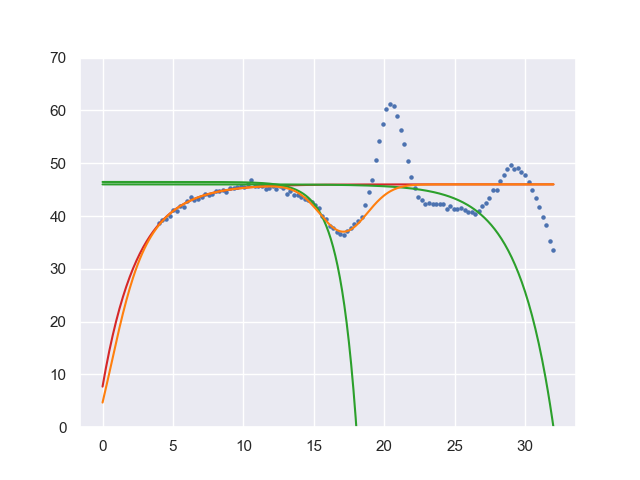

In [171]:
plt.close(9)
fig9, ax9 = plt.subplots(num=9)
xg = np.linspace(0, 32, 400)
xd = np.linspace(4, 32, 112)
# ax9.plot(xg, ROI_xmodel(xg, 48, -0.3, 0, 0.5, 1.7, 17, 2))

filt = xd < 18
xd2 = xd[filt]
y = peak_vals[filt]

p0=(45.98932155257467, -0.40511254082333636, -0.45145952676378365, 0.7578560682778519, 3.3294034945112485, 17.094255950785502, 1.0887325475324638)
# p0=(45.98932155257467, -0.40511254082333636, -0.45145952676378365, 0.7578560682778519, 3.3294034945112485, 17.094255950785502)
params, pcov = curve_fit(ROI_xmodel, xd2, y, p0=p0)

print(params)
print(np.sqrt(np.diag(pcov)))
ax9.plot(xg, sub_exp(xg, *(45.98932155, -0.40511254, -0.45145953)), color="tab:red")
ax9.plot(xg, sub_exp(-xg, *(45.98932155, -0.40511254, -32.0)), color="tab:green")
ax9.plot(xg, sub_exp(-xg, *(45.98932155, -0.80511254, -18.0, 0.01)), color="tab:green")
ax9.plot(xg, ROI_xmodel(xg, *params), color="tab:orange")
ax9.set_ylim(0, 70)
ax9.scatter(xd, peak_vals, s=5)
plt.show()